# Parametric Channel Attention Module (PCAM) Experiment
PCAM is inspired by the Convolutional Block Attention Module (CBAM), but enhances it by introducing learnable parameters within the activation functions and adaptively combining average and max pooling outputs in the channel attention mechanism.

PCAM has been built based on the extensive experiment below:  


## 0. Set-up

In [ ]:
pip install torchinfo

In [ ]:
# Import all necessary libraries for model building, training,
# evaluation, visualization, and dataset preparation.

import torch                     # PyTorch core
import torch.nn as nn            # PyTorch neural network module
import torch.optim as optim      # PyTorch optimization algorithms
from torchvision import models, transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from sklearn.metrics import average_precision_score
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize
from unittest.mock import patch
from torchvision.models import inception_v3
from torchvision.models import vgg19
from torchinfo import summary
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
import numpy as np
import pandas as pd
import cv2
import os
from datetime import datetime

# Set computation device to GPU if available
device = torch.device("cuda")
print(f"Running on: {device}")

Running on: cuda


**This notebook runs and saves all plots and tables per architecture so that running this model can be split amongst the group**

In [ ]:
current_architecture = 'resnet'  # 'vgg' or 'inception'
epochs = 5

## 1. Dataset Preparation

Data loader for CIFAR-10 with resizing to 224x224 to match pretrained ResNet input expectations:

In [ ]:
from torchvision.datasets import STL10
from torchvision import transforms
from torch.utils.data import DataLoader

def get_dataloaders():
    transform = transforms.Compose([
        transforms.Resize(224),  # Optional: Resize STL10 images to 224x224 if using models like ResNet
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
    ])

    trainset = STL10(root='./data', split='train', download=True, transform=transform)
    testset = STL10(root='./data', split='test', download=True, transform=transform)

    trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
    testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

    return trainloader, testloader

## 2. Building Attention Enhanced Convolutional Neural Network (CNN) models


#### Channel Attention Module

---


In [ ]:
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16, channel_activation_type='sigmoid', channel_pool_weight="yes"):
        super(ChannelAttention, self).__init__()

        # Adaptive pooling: compress feature maps to 1x1 by averaging and maxing across channel dimensions
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        # Shared MLP: two conv layers simulate a fully connected bottleneck structure
        self.fc1 = nn.Conv2d(in_planes, in_planes // ratio, kernel_size=1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Conv2d(in_planes // ratio, in_planes, kernel_size=1, bias=False)

        # Learnable parameter
        self.alpha_raw = nn.Parameter(torch.tensor(0.0))
        self.temperature = nn.Parameter(torch.tensor(1.0))

        # For condition
        self.pool_weight = channel_pool_weight

        # Activation functions
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))

        # Blend avg_out and max_out based on learnable alpha
        if self.pool_weight == "yes":
            alpha = torch.sigmoid(self.alpha_raw)
            out = alpha * avg_out + (1 - alpha) * max_out
        else:
            out = avg_out + max_out

        out = self.sigmoid(out)

        return out

#### Spatial Attention Module


#### Activation Functions to Output Values for Each Channel Position
**Sigmoid (default)**: Allows multiple regions to be highlighted. No competition, so the model can attend to several important areas.

**Parametric Sigmoid**: The temperature parameter allows adjusting the steepness of the sigmoid. A higher temperature makes it softer, spreading out the attention, while a lower temperature makes it sharper.

In [ ]:
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7, spatial_activation_type='sigmoid', spatial_pool_weight="yes"):
        super(SpatialAttention, self).__init__()

        # Padding must match kernel size to keep dimensions consistent.
        # Must ensure that attention map is the same spatial size as the input feature map
        padding = 3 if kernel_size == 7 else 1

        # 7x7 convolution on 2-channel input (avg + max across channels)
        in_channels = 1 if spatial_pool_weight == "yes" else 2
        self.conv1 = nn.Conv2d(in_channels, 1, kernel_size, padding=padding, bias=False)

        # Learnable parameter
        if spatial_pool_weight == "yes":
            self.alpha_raw = nn.Parameter(torch.tensor(0.0))
        else:
            self.register_parameter('alpha_raw', None)
        self.temperature = nn.Parameter(torch.ones(1))

        # For condition
        self.spatial_activation_type = spatial_activation_type
        self.pool_weight = spatial_pool_weight

        # Activation functions
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Channel-wise pooling to summarize across channels
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)

        # Blend avg_out and max_out based on learnable alpha
        if self.pool_weight == "yes":
            alpha = torch.sigmoid(self.alpha_raw)
            out = alpha * avg_out + (1 - alpha) * max_out
        else:
            out = torch.cat([avg_out, max_out], dim=1)

        # Use convolution layer to generate the spatial attention mask
        out = self.conv1(out)

        # Apply different activation functions
        if self.spatial_activation_type == "parametric_sigmoid":
            out = self.sigmoid(out / self.temperature)

        else:
            out = self.sigmoid(out)

        return out


### Adding CBAM to CNN architectures

This section wraps VGG19, ResNet18, and InceptionV3 with CBAM at early, middle, or late layer locations.

In [ ]:
class CBAM(nn.Module):
    def __init__(self, planes, ratio=16, kernel_size=7,
                 channel_activation_type='sigmoid', channel_pool_weight="yes",
                 spatial_activation_type='sigmoid', spatial_pool_weight="yes"):
        super(CBAM, self).__init__()
        self.ca = ChannelAttention(
            planes, ratio,
            channel_activation_type=channel_activation_type,
            channel_pool_weight=channel_pool_weight
        )
        self.sa = SpatialAttention(
            kernel_size,
            spatial_activation_type=spatial_activation_type,
            spatial_pool_weight=spatial_pool_weight
        )

    def forward(self, x):
        x = x * self.ca(x) # Apply channel attention first
        x = x * self.sa(x) # Then apply spatial attention
        return x # Return the feature map with attention applied


In [ ]:
# Helper function that inserts CBAM into a Sequential model at a specified index

def insert_cbam_sequential(module, index, cbam_module):
    layers = list(module.children()) # Breaks the existing Sequential into a list of layers
    layers.insert(index, cbam_module) # Inserts CBAM at the desired point
    return nn.Sequential(*layers)  # Reassemble - (* is the Python unpacking util: turns a list of layers into multiple arguments)

## 3. Model Building


---



### ResNet with CBAM:

- Custom ResNet18 wrapper that conditionally adds CBAM at different depths

In [ ]:
class ResNet18_CBAM(nn.Module):
    def __init__(self, attention_position="late", num_classes=10, spatial_activation_type='sigmoid', channel_activation_type='sigmoid', channel_pool_weight="yes", spatial_pool_weight="yes"):
        super(ResNet18_CBAM, self).__init__()
        base = models.resnet18(pretrained=True)  # Load pretrained ResNet18

        # Load pretrained ResNet18
        self.stem = nn.Sequential(base.conv1, base.bn1, base.relu, base.maxpool)
        self.layer1 = base.layer1 # Output: 64 channels
        self.layer2 = base.layer2 # Output: 128 channels
        self.layer3 = base.layer3 # Output: 256 channels
        self.layer4 = base.layer4 # Output: 512 channels
        self.avgpool = base.avgpool
        self.fc = nn.Linear(512, num_classes)


        # Conditionally attach CBAM to a specific ResNet block depending on the attention_position specified (CBAM is added to the first block in the specified layer group)
        # If 'none', this is passed over - we skip adding any attention block
        if attention_position == "early":
            self.layer1[0].cbam = CBAM(64, spatial_activation_type=spatial_activation_type, channel_activation_type=channel_activation_type, channel_pool_weight=channel_pool_weight, spatial_pool_weight=spatial_pool_weight)
            self.cbam_layer = self.layer1[0]
        elif attention_position == "middle":
            self.layer2[0].cbam = CBAM(128, spatial_activation_type=spatial_activation_type, channel_activation_type=channel_activation_type, channel_pool_weight=channel_pool_weight, spatial_pool_weight=spatial_pool_weight)
            self.cbam_layer = self.layer2[0]
        elif attention_position == "late":
            self.layer4[0].cbam = CBAM(512, spatial_activation_type=spatial_activation_type, channel_activation_type=channel_activation_type, channel_pool_weight=channel_pool_weight, spatial_pool_weight=spatial_pool_weight)
            self.cbam_layer = self.layer4[0]

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        # Apply CBAM only if attached
        if hasattr(self.layer1[0], 'cbam'):
            x = self.layer1[0].cbam(x)
        x = self.layer2(x)
        if hasattr(self.layer2[0], 'cbam'):
            x = self.layer2[0].cbam(x)
        x = self.layer3(x)
        x = self.layer4(x)
        if hasattr(self.layer4[0], 'cbam'):
            x = self.layer4[0].cbam(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


### InceptionV3 with CBAM:

In [ ]:
class InceptionV3_CBAM(nn.Module):
    def __init__(self, attention_position="late", num_classes=10,
                 spatial_activation_type='sigmoid', channel_activation_type='sigmoid',
                 channel_pool_weight="yes", spatial_pool_weight="yes"):
        super(InceptionV3_CBAM, self).__init__()
        inception = inception_v3(pretrained=True)

        self.stem = nn.Sequential(
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2),
            inception.Conv2d_3b_1x1,
            inception.Conv2d_4a_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        # Clone inception blocks for manual control
        self.Mixed_5b = inception.Mixed_5b  # Output: 192
        self.Mixed_5c = inception.Mixed_5c
        self.Mixed_5d = inception.Mixed_5d  # Output: 288
        self.Mixed_6a = inception.Mixed_6a  # Output: 768
        self.Mixed_6b = inception.Mixed_6b
        self.Mixed_6c = inception.Mixed_6c
        self.Mixed_6d = inception.Mixed_6d
        self.Mixed_6e = inception.Mixed_6e
        self.Mixed_7a = inception.Mixed_7a
        self.Mixed_7b = inception.Mixed_7b
        self.Mixed_7c = inception.Mixed_7c

        # Insert CBAM
        if attention_position == "early":
            self.Mixed_5b.cbam = CBAM(
                planes=192,
                spatial_activation_type=spatial_activation_type,
                channel_activation_type=channel_activation_type,
                channel_pool_weight=channel_pool_weight,
                spatial_pool_weight=spatial_pool_weight
            )
        elif attention_position == "middle":
            self.Mixed_5d.cbam = CBAM(
                planes=288,
                spatial_activation_type=spatial_activation_type,
                channel_activation_type=channel_activation_type,
                channel_pool_weight=channel_pool_weight,
                spatial_pool_weight=spatial_pool_weight
            )
        elif attention_position == "late":
            self.Mixed_6a.cbam = CBAM(
                planes=768,
                spatial_activation_type=spatial_activation_type,
                channel_activation_type=channel_activation_type,
                channel_pool_weight=channel_pool_weight,
                spatial_pool_weight=spatial_pool_weight
            )
        else:
            raise ValueError("attention_position must be 'early', 'middle', or 'late'")

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout()
        self.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.stem(x)

        # Manually forward through inception blocks with CBAM checks
        x = self.Mixed_5b(x)
        if hasattr(self.Mixed_5b, 'cbam'):
            x = self.Mixed_5b.cbam(x)

        x = self.Mixed_5c(x)
        x = self.Mixed_5d(x)
        if hasattr(self.Mixed_5d, 'cbam'):
            x = self.Mixed_5d.cbam(x)

        x = self.Mixed_6a(x)
        if hasattr(self.Mixed_6a, 'cbam'):
            x = self.Mixed_6a.cbam(x)

        x = self.Mixed_6b(x)
        x = self.Mixed_6c(x)
        x = self.Mixed_6d(x)
        x = self.Mixed_6e(x)
        x = self.Mixed_7a(x)
        x = self.Mixed_7b(x)
        x = self.Mixed_7c(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

### VGG-19 with CBAM:

In [ ]:
class VGG19_CBAM(nn.Module):
    def __init__(self, attention_position="late", num_classes=10,
                 spatial_activation_type='sigmoid', channel_activation_type='sigmoid',
                 channel_pool_weight="yes", spatial_pool_weight="yes"):
        super(VGG19_CBAM, self).__init__()

        # Load pretrained VGG19 and extract features
        vgg = vgg19(pretrained=True)
        features = list(vgg.features.children())

        # Define CBAM insert point
        if attention_position == "early":
            insert_idx = 5
        elif attention_position == "middle":
            insert_idx = 20
        elif attention_position == "late":
            insert_idx = 30

        # Find last Conv2d before insert_idx to get correct out_channels
        for i in range(insert_idx - 1, -1, -1):
            if isinstance(features[i], nn.Conv2d):
                planes = features[i].out_channels
                break

        # Insert CBAM module
        cbam = CBAM(planes,
                    spatial_activation_type=spatial_activation_type,
                    channel_activation_type=channel_activation_type,
                    channel_pool_weight=channel_pool_weight,
                    spatial_pool_weight=spatial_pool_weight)

        self.features = nn.Sequential(*features[:insert_idx], cbam, *features[insert_idx:])

        # Classifier
        self.avgpool = vgg.avgpool
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096), nn.ReLU(True), nn.Dropout(),
            nn.Linear(4096, 4096), nn.ReLU(True), nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

## 4. Model Summary


---


### ResNet Model Summary

In [ ]:
model = ResNet18_CBAM(attention_position="late", num_classes=10)
summary(model, input_size=(1, 3, 224, 224))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 167MB/s]


Layer (type:depth-idx)                        Output Shape              Param #
ResNet18_CBAM                                 [1, 10]                   --
├─Sequential: 1-1                             [1, 64, 56, 56]           --
│    └─Conv2d: 2-1                            [1, 64, 112, 112]         9,408
│    └─BatchNorm2d: 2-2                       [1, 64, 112, 112]         128
│    └─ReLU: 2-3                              [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                         [1, 64, 56, 56]           --
├─Sequential: 1-2                             [1, 64, 56, 56]           --
│    └─BasicBlock: 2-5                        [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                       [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2                  [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                         [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                       [1, 64, 56, 56]           36,864
│    │ 

### InceptionV3 Model Summary

In [ ]:
model = InceptionV3_CBAM(attention_position="late", num_classes=10)
summary(model, input_size=(1, 3, 299, 299))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 170MB/s] 


Layer (type:depth-idx)                        Output Shape              Param #
InceptionV3_CBAM                              [1, 10]                   --
├─Sequential: 1-1                             [1, 192, 35, 35]          --
│    └─BasicConv2d: 2-1                       [1, 32, 149, 149]         --
│    │    └─Conv2d: 3-1                       [1, 32, 149, 149]         864
│    │    └─BatchNorm2d: 3-2                  [1, 32, 149, 149]         64
│    └─BasicConv2d: 2-2                       [1, 32, 147, 147]         --
│    │    └─Conv2d: 3-3                       [1, 32, 147, 147]         9,216
│    │    └─BatchNorm2d: 3-4                  [1, 32, 147, 147]         64
│    └─BasicConv2d: 2-3                       [1, 64, 147, 147]         --
│    │    └─Conv2d: 3-5                       [1, 64, 147, 147]         18,432
│    │    └─BatchNorm2d: 3-6                  [1, 64, 147, 147]         128
│    └─MaxPool2d: 2-4                         [1, 64, 73, 73]           --
│    └─Basi

### VGG-19 Model Summary

In [ ]:
model = VGG19_CBAM(attention_position="late", num_classes=10)
summary(model, input_size=(1, 3, 224, 224))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 235MB/s]


Layer (type:depth-idx)                        Output Shape              Param #
VGG19_CBAM                                    [1, 10]                   --
├─Sequential: 1-1                             [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                            [1, 64, 224, 224]         1,792
│    └─ReLU: 2-2                              [1, 64, 224, 224]         --
│    └─Conv2d: 2-3                            [1, 64, 224, 224]         36,928
│    └─ReLU: 2-4                              [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-5                         [1, 64, 112, 112]         --
│    └─Conv2d: 2-6                            [1, 128, 112, 112]        73,856
│    └─ReLU: 2-7                              [1, 128, 112, 112]        --
│    └─Conv2d: 2-8                            [1, 128, 112, 112]        147,584
│    └─ReLU: 2-9                              [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-10                        [1, 128, 56, 56]          --
│   

Function that takes the architecture and position where attention is to be added. `num_classes` is always 10 because that is how many categories CIFAR10 has

In [ ]:
def get_attention_model(base='resnet', position='middle', num_classes=10, spatial_activation_type = 'sigmoid', channel_activation_type='sigmoid', channel_pool_weight="yes", spatial_pool_weight="yes"):
    if base == 'resnet':
        return ResNet18_CBAM(attention_position=position, num_classes=num_classes, spatial_activation_type=spatial_activation_type, channel_activation_type=channel_activation_type, channel_pool_weight=channel_pool_weight, spatial_pool_weight=spatial_pool_weight)
    elif base == 'vgg':
        return VGG19_CBAM(attention_position=position, num_classes=num_classes, spatial_activation_type=spatial_activation_type, channel_activation_type=channel_activation_type, channel_pool_weight=channel_pool_weight, spatial_pool_weight=spatial_pool_weight)
    elif base == 'inception':
        return InceptionV3_CBAM(attention_position=position, num_classes=num_classes, spatial_activation_type=spatial_activation_type, channel_activation_type=channel_activation_type, channel_pool_weight=channel_pool_weight, spatial_pool_weight=spatial_pool_weight)

## 5. Training and Evaluation

Includes Top-1, Top-5, Average Precision and gradient flow plot & logging alpha values

In [ ]:
def train_model(model, trainloader, testloader, num_classes=10, epochs=epochs, lr=0.0001):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    grad_norms = []
    alpha_log = []
    spatial_alpha_log = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        total_norm = 0.0

        for inputs, labels in tqdm(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            norm = sum(p.grad.data.norm(2).item() for p in model.parameters() if p.grad is not None)
            total_norm += norm
            optimizer.step()
            running_loss += loss.item()

        grad_norms.append(total_norm / len(trainloader))

        # Evaluation
        top1, top5, ap = evaluate_model(model, testloader, num_classes)
        print(f"Epoch {epoch+1}: Loss={running_loss:.4f}, GradNorm={grad_norms[-1]:.4f}, Top1={top1:.2f}%, Top5={top5:.2f}%, AP={ap:.4f}")

        # Track alphas if CBAM present
        if hasattr(model, 'cbam_layer') and hasattr(model.cbam_layer, 'cbam'):
            ca = model.cbam_layer.cbam.ca
            sa = model.cbam_layer.cbam.sa

            alpha_val = torch.sigmoid(ca.alpha_raw).item() if ca.alpha_raw is not None else None
            spatial_val = torch.sigmoid(sa.alpha_raw).item() if sa.alpha_raw is not None else None

            if alpha_val is not None:
                alpha_log.append(alpha_val)
                print(f"Learned channel alpha at epoch {epoch + 1}: {alpha_val:.4f}")
            if spatial_val is not None:
                spatial_alpha_log.append(spatial_val)
                print(f"Learned spatial alpha at epoch {epoch + 1}: {spatial_val:.4f}")

        if top1 > best_acc:
            best_acc = top1
            best_model_wts = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model_wts)

    # Plot channel & spatial alpha (if any)
    if alpha_log or spatial_alpha_log:
        plt.figure()
        if alpha_log:
            plt.plot(range(1, len(alpha_log)+1), alpha_log, label='Channel alpha')
        if spatial_alpha_log:
            plt.plot(range(1, len(spatial_alpha_log)+1), spatial_alpha_log, label='Spatial alpha')
        plt.title("Learned Alpha Over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Alpha Value")
        plt.legend()
        plt.grid(True)
        plt.show()

    # Plot gradient norm
    plt.figure()
    plt.plot(range(1, epochs+1), grad_norms, marker='o', label='Gradient Norm')
    plt.title("Gradient Norm per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Gradient L2 Norm")
    plt.grid(True)
    plt.legend()
    plt.show()

    return model, {
        'top1': best_acc,
        'grad_norms': grad_norms,
        'alpha_log': alpha_log,
        'spatial_alpha_log': spatial_alpha_log
    }



In [ ]:
def evaluate_model(model, testloader, num_classes=10):
    model.eval()
    correct = 0
    top5_correct = 0
    total = 0
    all_probs = []
    all_targets = []

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)

            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            top5 = torch.topk(outputs, 5, dim=1)[1]
            top5_correct += sum([labels[i] in top5[i] for i in range(labels.size(0))])
            all_probs.append(probs.cpu())
            all_targets.append(labels.cpu())

    top1_acc = correct / total * 100
    top5_acc = top5_correct / total * 100
    ap_score = compute_average_precision(all_targets, all_probs)
    return top1_acc, top5_acc, ap_score

In [ ]:
def compute_average_precision(all_targets, all_probs):
    num_classes=10

    # Concatenate tensors
    y_true = torch.cat(all_targets).cpu().numpy()
    y_score = torch.cat(all_probs).cpu().numpy()

    # Binarize targets (e.g., [3] → [0,0,0,1,0,0,...])
    y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))

    # Check shape match
    assert y_true_bin.shape == y_score.shape, f"Shape mismatch: {y_true_bin.shape} vs {y_score.shape}"

    # Compute macro-average precision
    ap = average_precision_score(y_true_bin, y_score, average='macro')

    print("y_true_bin shape:", y_true_bin.shape)  # Should be [N, 10]
    print("y_score shape:", y_score.shape)        # Should be [N, 10]
    print("y_score sample:", y_score[0])
    print("y_true one-hot:", y_true_bin[0])

    return ap


## 6. Comparison between Vanila, CBAM and Our Potential Model

---



### Interpretability

Our model should be the one outperforming all other model based on the outcome above.

In [ ]:
def generate_gradcam_data(model, dataloader, target_layer):
    model.eval()

    gradients, activations = [], []

    def forward_hook(module, input, output): activations.append(output)
    def backward_hook(module, grad_input, grad_output): gradients.append(grad_output[0])

    fh = target_layer.register_forward_hook(forward_hook)
    bh = target_layer.register_full_backward_hook(backward_hook)

    input_images, cams, pred_probs, pred_labels = [], [], [], []
    seen_classes = set()

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        for i in range(inputs.size(0)):
            label = labels[i].item()
            if label in seen_classes:
                continue

            seen_classes.add(label)
            if len(seen_classes) >= 10:
                break

            gradients.clear()
            activations.clear()

            input_i = inputs[i].unsqueeze(0)
            output_i = model(input_i)
            prob_i = torch.nn.functional.softmax(output_i, dim=1)
            pred_i = torch.argmax(prob_i, dim=1)

            one_hot = torch.zeros_like(output_i)
            one_hot[0][pred_i] = 1
            output_i.backward(gradient=one_hot)

            grad = gradients[0].detach()[0]
            act = activations[0].detach()[0]
            weights = torch.mean(grad, dim=(1, 2))
            cam = torch.zeros_like(act[0])
            for j, w in enumerate(weights):
                cam += w * act[j]
            cam = torch.relu(cam)
            cam -= cam.min()
            cam /= cam.max()

            img = inputs[i].detach().cpu().permute(1, 2, 0).numpy()
            img = (img * 0.5 + 0.5) * 255
            img = img.astype(np.uint8)

            cam_resized = cv2.resize(cam.cpu().numpy(), (img.shape[1], img.shape[0]))
            heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
            heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
            overlay = cv2.addWeighted(img, 0.5, heatmap, 0.5, 0)

            input_images.append(img)
            cams.append(overlay)
            pred_probs.append(prob_i[0][pred_i].item())
            pred_labels.append(label)

        if len(seen_classes) >= 10:
            break

    fh.remove()
    bh.remove()
    return input_images, cams, pred_labels, pred_probs

In [ ]:
def plot_gradcam_comparison_grid(inputs, cams_vanilla, cams_cbam, cams_psam, labels, probs_v, probs_c, probs_p, class_names):
    fig, axes = plt.subplots(4, len(inputs), figsize=(2 * len(inputs), 8))
    rows = ['Input image', 'Vanilla', 'CBAM', 'PCAM']

    for col in range(len(inputs)):
        axes[0, col].imshow(inputs[col])
        axes[1, col].imshow(cams_vanilla[col])
        axes[2, col].imshow(cams_cbam[col])
        axes[3, col].imshow(cams_psam[col])

        for row in range(4):
            axes[row, col].axis('off')
            if row > 0:
                prob = [probs_v, probs_c, probs_p][row - 1][col]
                axes[row, col].set_title(f"P={prob:.2f}", fontsize=8)

        axes[0, col].set_title(class_names[labels[col]], fontsize=9)

    for ax, row_name in zip(axes[:, 0], rows):
        ax.set_ylabel(row_name, rotation=0, labelpad=40, fontsize=10, va='center')

    plt.tight_layout()
    plt.show()

100%|██████████| 2.64G/2.64G [02:53<00:00, 15.2MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 237MB/s]
100%|██████████| 79/79 [00:06<00:00, 12.33it/s]


y_true_bin shape: (8000, 10)
y_score shape: (8000, 10)
y_score sample: [3.5288907e-04 5.3273991e-04 4.5194363e-04 3.2297859e-04 2.4660651e-03
 4.2483822e-02 9.5276481e-01 3.5465544e-04 1.2639390e-04 1.4378320e-04]
y_true one-hot: [0 0 0 0 0 0 1 0 0 0]
Epoch 1: Loss=40.6757, GradNorm=17.0390, Top1=94.26%, Top5=99.90%, AP=0.9860


100%|██████████| 79/79 [00:05<00:00, 15.69it/s]


y_true_bin shape: (8000, 10)
y_score shape: (8000, 10)
y_score sample: [5.4613865e-05 2.3851535e-04 1.1594295e-04 7.4403884e-05 7.0674828e-04
 1.3587423e-02 9.8489362e-01 2.2555662e-04 4.3375443e-05 5.9748949e-05]
y_true one-hot: [0 0 0 0 0 0 1 0 0 0]
Epoch 2: Loss=6.0014, GradNorm=9.0065, Top1=94.73%, Top5=99.84%, AP=0.9866


100%|██████████| 79/79 [00:05<00:00, 15.34it/s]


y_true_bin shape: (8000, 10)
y_score shape: (8000, 10)
y_score sample: [1.1117407e-05 3.9930310e-05 1.8827041e-05 7.7243831e-06 1.2399010e-04
 4.7660677e-04 9.9928421e-01 1.9678777e-05 8.4249123e-06 9.5432270e-06]
y_true one-hot: [0 0 0 0 0 0 1 0 0 0]
Epoch 3: Loss=1.3953, GradNorm=3.0298, Top1=95.26%, Top5=99.84%, AP=0.9897


100%|██████████| 79/79 [00:05<00:00, 15.33it/s]


y_true_bin shape: (8000, 10)
y_score shape: (8000, 10)
y_score sample: [7.1988998e-06 1.8378267e-05 1.0942040e-05 6.0222928e-06 2.8358791e-05
 1.7214530e-04 9.9972528e-01 1.7845419e-05 6.8887421e-06 6.9282592e-06]
y_true one-hot: [0 0 0 0 0 0 1 0 0 0]
Epoch 4: Loss=0.8728, GradNorm=2.4346, Top1=95.33%, Top5=99.78%, AP=0.9895


100%|██████████| 79/79 [00:05<00:00, 15.35it/s]


y_true_bin shape: (8000, 10)
y_score shape: (8000, 10)
y_score sample: [3.1762365e-06 1.6253640e-05 1.0207543e-05 3.7690263e-06 4.3969034e-05
 4.2568095e-04 9.9947220e-01 1.4838877e-05 3.6153715e-06 6.2847998e-06]
y_true one-hot: [0 0 0 0 0 0 1 0 0 0]
Epoch 5: Loss=1.4957, GradNorm=4.4602, Top1=95.23%, Top5=99.91%, AP=0.9884


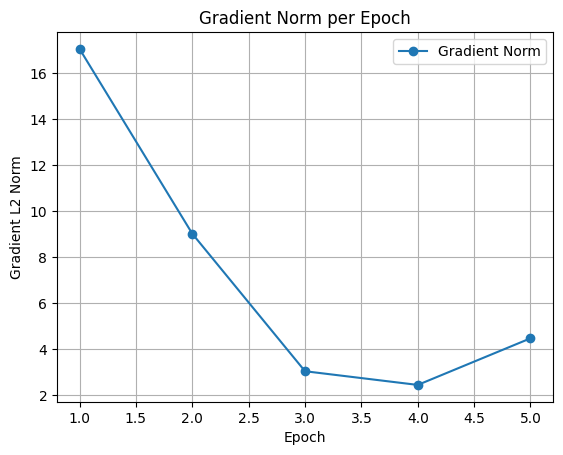

100%|██████████| 79/79 [00:05<00:00, 15.38it/s]


y_true_bin shape: (8000, 10)
y_score shape: (8000, 10)
y_score sample: [0.00260354 0.00474731 0.00246319 0.00314639 0.00749845 0.10809908
 0.861613   0.00485953 0.00173682 0.00323271]
y_true one-hot: [0 0 0 0 0 0 1 0 0 0]
Epoch 1: Loss=55.5513, GradNorm=14.1509, Top1=93.35%, Top5=99.84%, AP=0.9821
Learned channel alpha at epoch 1: 0.5000


100%|██████████| 79/79 [00:05<00:00, 15.49it/s]


y_true_bin shape: (8000, 10)
y_score shape: (8000, 10)
y_score sample: [9.9814602e-04 1.6620591e-03 1.0960463e-03 1.7295055e-03 3.3297152e-03
 5.3209793e-02 9.3481749e-01 1.0982509e-03 7.5251673e-04 1.3064932e-03]
y_true one-hot: [0 0 0 0 0 0 1 0 0 0]
Epoch 2: Loss=8.0708, GradNorm=9.3331, Top1=94.65%, Top5=99.86%, AP=0.9875
Learned channel alpha at epoch 2: 0.5000


100%|██████████| 79/79 [00:05<00:00, 15.56it/s]


y_true_bin shape: (8000, 10)
y_score shape: (8000, 10)
y_score sample: [6.2146765e-04 6.7982310e-04 3.6060053e-04 2.3662645e-04 1.3389761e-03
 3.5237039e-03 9.9165875e-01 5.3740270e-04 3.4228704e-04 7.0040877e-04]
y_true one-hot: [0 0 0 0 0 0 1 0 0 0]
Epoch 3: Loss=2.4550, GradNorm=5.5814, Top1=94.80%, Top5=99.76%, AP=0.9873
Learned channel alpha at epoch 3: 0.5000


100%|██████████| 79/79 [00:05<00:00, 13.47it/s]


y_true_bin shape: (8000, 10)
y_score shape: (8000, 10)
y_score sample: [3.7159833e-05 1.7732622e-05 1.9772380e-05 1.2699841e-05 8.4364045e-05
 4.4233055e-04 9.9926490e-01 6.0162227e-05 1.1933809e-05 4.8999504e-05]
y_true one-hot: [0 0 0 0 0 0 1 0 0 0]
Epoch 4: Loss=1.3652, GradNorm=3.8454, Top1=95.00%, Top5=99.80%, AP=0.9882
Learned channel alpha at epoch 4: 0.5000


100%|██████████| 79/79 [00:05<00:00, 15.60it/s]


y_true_bin shape: (8000, 10)
y_score shape: (8000, 10)
y_score sample: [8.5698623e-05 7.1282564e-05 5.2209263e-05 5.3076772e-05 3.2121892e-04
 4.0851533e-03 9.9497896e-01 1.8811088e-04 4.4864664e-05 1.1939939e-04]
y_true one-hot: [0 0 0 0 0 0 1 0 0 0]
Epoch 5: Loss=0.6981, GradNorm=2.0437, Top1=95.35%, Top5=99.80%, AP=0.9883
Learned channel alpha at epoch 5: 0.5000


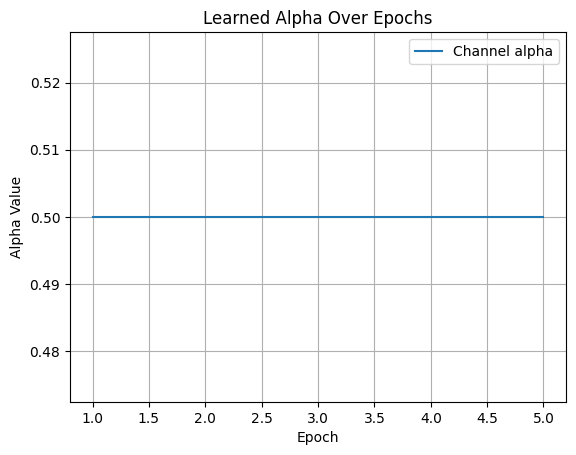

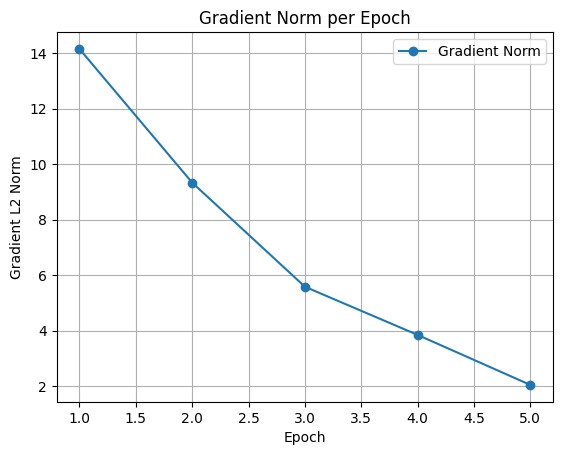

100%|██████████| 79/79 [00:05<00:00, 14.72it/s]


y_true_bin shape: (8000, 10)
y_score shape: (8000, 10)
y_score sample: [0.00411021 0.00545498 0.00646923 0.00341976 0.0123651  0.13637841
 0.8196598  0.00457164 0.00315913 0.00441168]
y_true one-hot: [0 0 0 0 0 0 1 0 0 0]
Epoch 1: Loss=59.0782, GradNorm=13.6218, Top1=93.73%, Top5=99.85%, AP=0.9845
Learned channel alpha at epoch 1: 0.4983


100%|██████████| 79/79 [00:05<00:00, 15.37it/s]


y_true_bin shape: (8000, 10)
y_score shape: (8000, 10)
y_score sample: [0.00147528 0.00144137 0.00317054 0.00212419 0.00511608 0.09899469
 0.8816098  0.00140973 0.00151638 0.00314197]
y_true one-hot: [0 0 0 0 0 0 1 0 0 0]
Epoch 2: Loss=9.1264, GradNorm=9.2022, Top1=94.74%, Top5=99.91%, AP=0.9875
Learned channel alpha at epoch 2: 0.4972


100%|██████████| 79/79 [00:05<00:00, 15.30it/s]


y_true_bin shape: (8000, 10)
y_score shape: (8000, 10)
y_score sample: [4.1333120e-04 3.2603729e-04 7.2075211e-04 3.7033812e-04 9.2002039e-04
 7.6543768e-03 9.8842490e-01 3.1563180e-04 2.3009548e-04 6.2445231e-04]
y_true one-hot: [0 0 0 0 0 0 1 0 0 0]
Epoch 3: Loss=2.1596, GradNorm=3.5671, Top1=95.54%, Top5=99.88%, AP=0.9890
Learned channel alpha at epoch 3: 0.4966


100%|██████████| 79/79 [00:05<00:00, 15.43it/s]


y_true_bin shape: (8000, 10)
y_score shape: (8000, 10)
y_score sample: [2.5835042e-04 2.6431744e-04 4.9458386e-04 3.6577240e-04 1.5912016e-03
 4.1756351e-03 9.9153554e-01 4.0437517e-04 2.1033146e-04 6.9996453e-04]
y_true one-hot: [0 0 0 0 0 0 1 0 0 0]
Epoch 4: Loss=1.1233, GradNorm=2.6781, Top1=95.30%, Top5=99.85%, AP=0.9894
Learned channel alpha at epoch 4: 0.4962


100%|██████████| 79/79 [00:05<00:00, 15.24it/s]


y_true_bin shape: (8000, 10)
y_score shape: (8000, 10)
y_score sample: [8.4065209e-04 1.0785250e-03 1.1841004e-03 6.8744196e-04 5.5202232e-03
 1.3092694e-02 9.7376841e-01 1.8839008e-03 6.4649165e-04 1.2973731e-03]
y_true one-hot: [0 0 0 0 0 0 1 0 0 0]
Epoch 5: Loss=0.8859, GradNorm=2.5752, Top1=94.62%, Top5=99.83%, AP=0.9882
Learned channel alpha at epoch 5: 0.4958


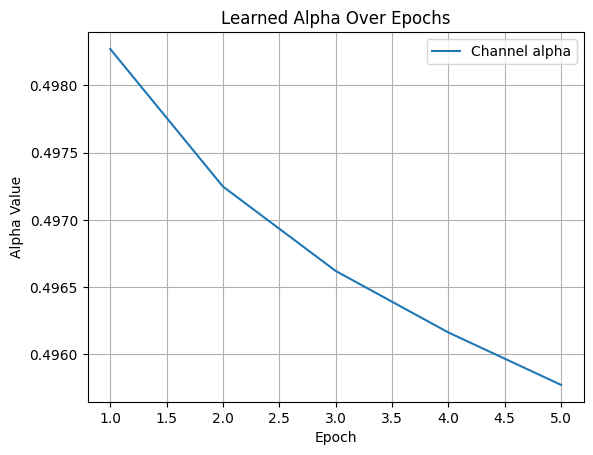

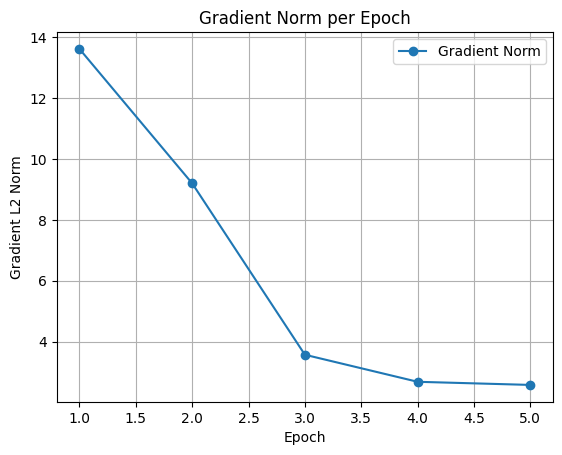

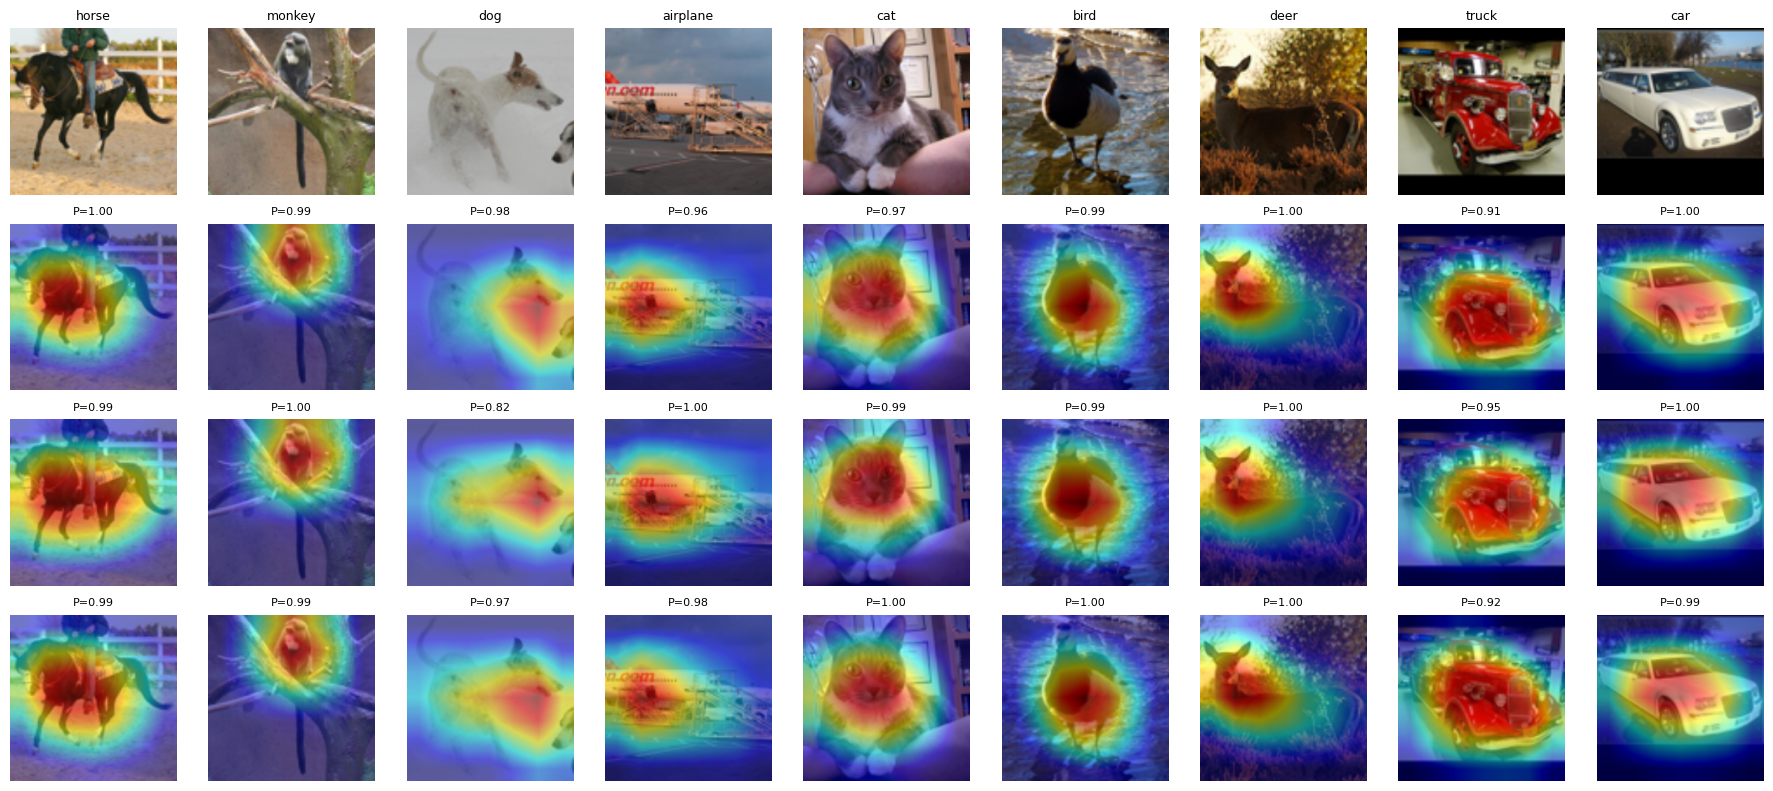

In [ ]:
# Load dataset
trainloader, testloader = get_dataloaders()
class_names = STL10('./data').classes

if current_architecture == 'resnet':
    # Vanilla ResNet
    model_vanilla = models.resnet18(pretrained=True)
    model_vanilla.fc = nn.Linear(512, 10)

    # CBAM ResNet
    model_cbam = ResNet18_CBAM(
        attention_position="late",
        spatial_activation_type='sigmoid',
        channel_activation_type='sigmoid',
        channel_pool_weight="no",
        spatial_pool_weight="no"
    )

    # PSAM ResNet
    model_psam = ResNet18_CBAM(
        attention_position="late",
        spatial_activation_type='parametric_sigmoid',
        channel_activation_type='sigmoid',
        channel_pool_weight="yes",
        spatial_pool_weight="no"
    )

    def get_target_layer(model):
        return model.layer4[1].conv2

elif current_architecture == 'vgg':
    # Vanilla VGG
    model_vanilla = models.vgg19(pretrained=True)
    model_vanilla.classifier[6] = nn.Linear(4096, 10)

    # CBAM VGG
    model_cbam = VGG19_CBAM(
        attention_position="late",
        spatial_activation_type='sigmoid',
        channel_activation_type='sigmoid',
        channel_pool_weight="no",
        spatial_pool_weight="no"
    )

    # PSAM VGG
    model_psam = VGG19_CBAM(
        attention_position="late",
        spatial_activation_type='parametric_sigmoid',
        channel_activation_type='sigmoid',
        channel_pool_weight="no",
        spatial_pool_weight="yes"
    )

    def get_target_layer(model):
        return model.features[28]

elif current_architecture == 'inception':
    # Vanilla Inception
    model_vanilla = models.inception_v3(pretrained=True, aux_logits=False)
    model_vanilla.fc = nn.Linear(2048, 10)

    # CBAM Inception
    model_cbam = InceptionV3_CBAM(
        attention_position="late",
        spatial_activation_type='sigmoid',
        channel_activation_type='sigmoid',
        channel_pool_weight="no",
        spatial_pool_weight="no"
    )

    # PSAM Inception
    model_psam = InceptionV3_CBAM(
        attention_position="late",
        spatial_activation_type='parametric_sigmoid',
        channel_activation_type='sigmoid',
        channel_pool_weight="yes",
        spatial_pool_weight="no"
    )

    def get_target_layer(model):
        return model.Mixed_7c

else:
    raise ValueError("Invalid architecture selected.")

trained_vanilla, metrics_vanilla = train_model(model_vanilla.to(device), trainloader, testloader, epochs)
trained_cbam, metrics_cbam = train_model(model_cbam.to(device), trainloader, testloader, epochs)
trained_psam, metrics_psam = train_model(model_psam.to(device), trainloader, testloader, epochs)

# Grad-CAM Generation
target_layer_vanilla = get_target_layer(trained_vanilla)
input_imgs, cam_vanilla, labels_unique, prob_v = generate_gradcam_data(
    trained_vanilla, testloader, target_layer_vanilla)

target_layer_cbam = get_target_layer(trained_cbam)
_, cam_cbam, _, prob_cbam = generate_gradcam_data(
    trained_cbam, testloader, target_layer_cbam)

target_layer_psam = get_target_layer(trained_psam)
_, cam_psam, _, prob_psam = generate_gradcam_data(
    trained_psam, testloader, target_layer_psam)

# Grad-CAM Comparison Grid
plot_gradcam_comparison_grid(
    input_imgs, cam_vanilla, cam_cbam, cam_psam,
    labels_unique, prob_v, prob_cbam, prob_psam, class_names
)


### Gradient Flow

The L2 norm of gradients tells you about the overall "strength" of the gradients during backpropagation. It's a single number summarising how large the gradients are across all parameters in the model.

**Higher values**: indicate stronger gradient signals

**Lower values**: suggest weaker gradients, which might mean slower learning or even potential vanishing gradients

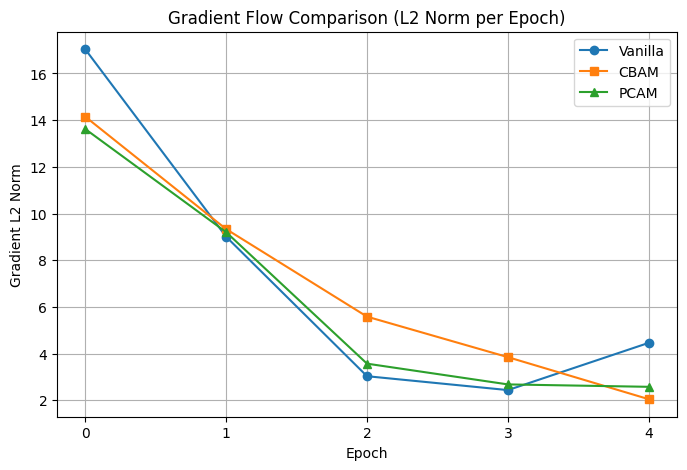

In [ ]:
# Plot gradient flow comparison
plt.figure(figsize=(8, 5))
plt.plot(metrics_vanilla['grad_norms'], label='Vanilla', marker='o')
plt.plot(metrics_cbam['grad_norms'], label='CBAM', marker='s')
plt.plot(metrics_psam['grad_norms'], label='PCAM', marker='^')
plt.title("Gradient Flow Comparison (L2 Norm per Epoch)")
plt.xlabel("Epoch")
plt.ylabel("Gradient L2 Norm")
plt.legend()
plt.grid(True)

plt.xticks(np.arange(0, len(metrics_vanilla['grad_norms']), 1))

plt.show()

In [ ]:
# Calculate gradient norm variance
vanilla_var = np.var(metrics_vanilla['grad_norms'])
cbam_var = np.var(metrics_cbam['grad_norms'])
psam_var = np.var(metrics_psam['grad_norms'])

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Model': ['Vanilla', 'CBAM (sigmoid)', 'PCAM (parametric sigmoid)'],
    'Gradient Norm Variance': [vanilla_var, cbam_var, psam_var]
})

# Display the table
print(comparison_df.to_string(index=False))

                    Model  Gradient Norm Variance
                  Vanilla               29.534906
           CBAM (sigmoid)               18.621564
PCAM (parametric sigmoid)               19.297740


### Weight Probing

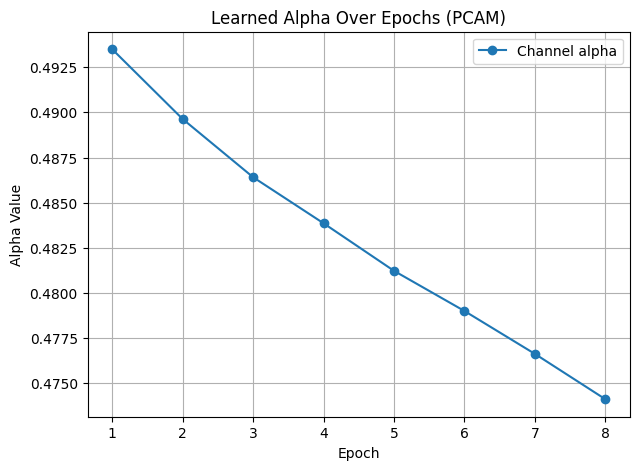

In [ ]:
def plot_psam_alpha_trend(metrics_psam):
    channel_alpha = metrics_psam.get('alpha_log', [])
    spatial_alpha = metrics_psam.get('spatial_alpha_log', [])
    epochs = list(range(1, len(channel_alpha) + 1))

    if not channel_alpha and not spatial_alpha:
        print("No alpha values recorded.")
        return

    plt.figure(figsize=(7, 5))
    if channel_alpha:
        plt.plot(epochs, channel_alpha, label="Channel alpha", marker='o')
    if spatial_alpha:
        plt.plot(epochs, spatial_alpha, label="Spatial alpha", marker='s')

    plt.title("Learned Alpha Over Epochs (PCAM)")
    plt.xlabel("Epoch")
    plt.ylabel("Alpha Value")
    plt.legend()
    plt.grid(True)

    # Set x-ticks to whole numbers only
    plt.xticks(np.arange(1, len(epochs) + 1, 1))

    plt.show()

plot_psam_alpha_trend(metrics_psam)

## Save Results

In [ ]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_dir = f"outputs/{current_architecture}_{timestamp}"
os.makedirs(output_dir, exist_ok=True)

# CSV
df_results.to_csv(f"{output_dir}/results_{current_architecture}.csv", index=False)

# LaTeX
with open(f"{output_dir}/results_{current_architecture}.tex", "w") as f:
    f.write(latex_table)


# Images
for i in range(len(input_imgs)):
    fig, axes = plt.subplots(1, 4, figsize=(12, 3))

    # Input image (normalize-safe to avoid err)
    input_img = input_imgs[i]
    if isinstance(input_img, torch.Tensor):
        input_img = input_img.permute(1, 2, 0).cpu().numpy()  # [C, H, W] → [H, W, C]
    input_img = (input_img * 0.5 + 0.5).clip(0, 1)  # unnormalize
    axes[0].imshow(input_img)
    axes[0].set_title("Input")

    # Grad-CAM
    axes[1].imshow(cam_vanilla[i], cmap='jet')
    axes[1].set_title("Vanilla")

    # CBAM
    axes[2].imshow(cam_cbam[i], cmap='viridis')
    axes[2].set_title("CBAM")

    # PSAM
    axes[3].imshow(cam_psam[i], cmap='viridis')
    axes[3].set_title("PSAM")

    for ax in axes:
        ax.axis('off')

    plt.tight_layout()
    plt.savefig(f"{output_dir}/compare_img_{i}.png", dpi=300)
    plt.close()


for i in range(len(input_imgs)):
    input_img = input_imgs[i]

    # Save heatmaps
    np.save(f"{output_dir}/input_{i}.npy", input_img)
    np.save(f"{output_dir}/vanilla_{i}.npy", cam_vanilla[i])
    np.save(f"{output_dir}/cbam_{i}.npy", cam_cbam[i])
    np.save(f"{output_dir}/psam_{i}.npy", cam_psam[i])

In [ ]:
# utility to download all results
from google.colab import files
!zip -r outputs.zip outputs
files.download("/content/outputs.zip")

updating: outputs/ (stored 0%)
updating: outputs/resnet_20250426_230227/ (stored 0%)
updating: outputs/resnet_20250426_230227/vanilla_7.npy (deflated 29%)
updating: outputs/resnet_20250426_230227/compare_img_3.png (deflated 8%)
updating: outputs/resnet_20250426_230227/compare_img_2.png (deflated 9%)
updating: outputs/resnet_20250426_230227/compare_img_6.png (deflated 9%)
updating: outputs/resnet_20250426_230227/input_8.npy (deflated 53%)
updating: outputs/resnet_20250426_230227/cbam_7.npy (deflated 28%)
updating: outputs/resnet_20250426_230227/compare_img_0.png (deflated 9%)
updating: outputs/resnet_20250426_230227/vanilla_0.npy (deflated 30%)
updating: outputs/resnet_20250426_230227/psam_0.npy (deflated 30%)
updating: outputs/resnet_20250426_230227/compare_img_4.png (deflated 9%)
updating: outputs/resnet_20250426_230227/input_3.npy (deflated 26%)
updating: outputs/resnet_20250426_230227/compare_img_7.png (deflated 9%)
updating: outputs/resnet_20250426_230227/compare_img_8.png (deflate

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>